## TERM DEPOSIT MARKETING
In this project, various bank customer data such as age, job, marital status, education etc. are used to predict if a customer will subscribe to a term deposit account or not.

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [2]:
df1 =  pd.read_csv('term-deposit-marketing-2020.csv')

In [3]:
df1.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [4]:
df1.info() # no null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


<AxesSubplot:xlabel='y', ylabel='count'>

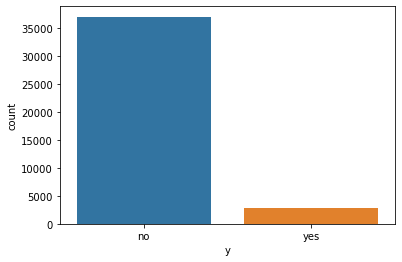

In [5]:
# The dataset is highly imbalanced. Less than 10 % are the 'yes' group (subscribed to a term deposit account)
# This is the group that is of interest to us. 
# That is, which customer characteristics will make him/her to subscribe to a term deposit account

sns.countplot(x='y', data=df1)

## Chi Square Test


Many of the features such as job, marital status, education have categorical values. One of the initial steps would be to determine if these features have any association to the outcome (i.e. said 'yes' or 'no' to a term deposit account subscription. Our null and alternate hypothesis are as follows;

NULL HYPOTHESIS H0: Categorical variable tested is independent (i.e. not associated with) of the outcome variable 'y'
ALTERNATE HYPOTHESIS H1: Categorical variable tested is not independent (i.e. associated with) of the outcome variable 'y'.

We will use the Chi Square or the Goodness of Fit test to check the independence of these variables and a p value < 0.05 will be considered sufficient to reject the NULL HYPOTHESIS.

In [31]:
# The following function calculates the Chi Square p-value when comparing the categorical variable in list cat_var
# against the outcome variable 'y'  ('yes' or 'no')


cat_var = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'day', 'month', 'campaign']
def chi_sq (df):
    """
    INPUT : Dataframe containing categorical data for columns specified in cat_var
    The function calculates the Chi-Square p values when comparing between each of the variables and the output variable 'y'
    OUTPUT : a dataframe containing the p-values corresponding to each of the variables
    """
    p_Vals_dict = {}
    for feat in cat_var:
        cross_tab = pd.crosstab(df1[feat], df1['y'])
        chiVal, pVal,degfrdm, exp = chi2_contingency(cross_tab)
        p_Vals_dict[feat] = pVal
    
    p_Vals_df = pd.DataFrame(index = ['Job Type', 'Marital Status', 'Education Level', 'Default History', 
                                      'Housing Loan', 'Personal Loan', 'Contact Method', 'Last Contact Day', 
                                      'Last Contact Month', 'Number of Contacts'], 
                             data = p_Vals_dict.values(), columns = ['p-value'])
    return p_Vals_df
    

In [32]:
chi_sq(df1)

,p-value
Job Type,1.676135e-26
Marital Status,3.091031e-30
Education Level,8.061911e-21
Default History,2.137353e-01
Housing Loan,2.048343e-27
Personal Loan,6.395487e-10
Contact Method,7.242047e-71
Last Contact Day,4.733110e-70
Last Contact Month,0.000000e+00
Number of Contacts,5.174950e-06


With the exception of default history, the p value is less than 0.05 for all the categorical features tested. This indicates that, for those features, we can safely reject the null hypothesis. That is, there is no association between these features and the choice of a customer to sign up for a term deposit account (or not). However, with default history, there is an association with the choice (which makes sense).

## Feature Engineering
Convert the categorical variables with text into dummy variables.

In [33]:
# make a deep copy of df1
df2 = df1.copy()

In [34]:
# replace all 'no's with 0 and 'yes' with 1 in the whole dataframe
df2.replace({'no':0, 'yes':1}, inplace = True)

In [130]:
df2.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,0,2143,1,0,unknown,5,may,261,1,0
1,44,technician,single,secondary,0,29,1,0,unknown,5,may,151,1,0
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,may,76,1,0
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,may,92,1,0
4,33,unknown,single,unknown,0,1,0,0,unknown,5,may,198,1,0


In [35]:
#create dummy columns for the following columns, and drop the first of the dummy columns
df3 = pd.get_dummies(df2, columns=['job','marital','month','education','contact', 'day'], drop_first=True)

In [36]:
df3.head()

,age,default,balance,housing,loan,duration,campaign,y,job_blue-collar,job_entrepreneur,...,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31
0,58,0,2143,1,0,261,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,44,0,29,1,0,151,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,33,0,2,1,1,76,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,47,0,1506,1,0,92,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,33,0,1,0,0,198,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
# specify dependent and independent variables
X = df3.drop('y', axis=1)
y = df3['y']

## Train-test split
As we have already seen, the dataset is heavily imbalanced in favour of the 'no' group (i.e. those who do not subscribe to a term deposit account). Before we balance the data using SMOTE, we will do train-test split and only resample the training set. SMOTE uses the K-Nearest Neighbour (KNN) method to resample data points.

In [40]:
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = 0.25, random_state=5)
X_train.shape, X_test.shape

((30000, 65), (10000, 65))

In [49]:
y_train.value_counts() # the 'no' (0) group is about 13 fold larger than the 'yes' (1) group 

0    27868
1     2132
Name: y, dtype: int64

In [50]:
#create an instance of SMOTE and specify the minority class tobe resampled
smote = SMOTE(sampling_strategy = 'minority')
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

In [51]:
y_train_sm.value_counts() # after resampling, the two groups in the training set are now balanced.

1    27868
0    27868
Name: y, dtype: int64

## XGB Classifier Model as an initial test

In [68]:
# train a XGB Classifier model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_estimators=100, learning_rate=0.4, max_depth = 5)
xgb.fit(X_train_sm, y_train_sm)
pred = xgb.predict(X_test)

In [69]:
print('Test Accuracy:', xgb.score(X_test, y_test))
print('Train Accuracy:',xgb.score(X_train_sm, y_train_sm))
# the train and test accuracies math closely... but...

Test Accuracy: 0.9281
Train Accuracy: 0.9797617338883307


In [70]:
# the precision, recall and f1-scores for group 1 are still quite poor, even with SMOTE resampling
print(classification_report(y_test,pred))
print(confusion_matrix(y_test,pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      9236
           1       0.53      0.46      0.50       764

    accuracy                           0.93     10000
   macro avg       0.75      0.71      0.73     10000
weighted avg       0.92      0.93      0.93     10000

[[8927  309]
 [ 410  354]]


As an initial test, we see that the XGB model afforded a good overall accuracy score BUT the model's ability to correctly identify customers who will subscribe to a term deposit account (group 1) is poor. Perhaps, hyperparameter tuning may yield better parameters to improve the XGB model? 

# REST OF THE NOTEBOOK IS INCOMPLETE - work in progress

## Test Classification by Logistic Regression, Support Vector Machine, Random Forest Classifier and XG Boost Classifier Models

In [53]:
#Define a function to sequentially test Logistic Regression, Support Vector, Random Forest Classifier and XG Boost Classifier
# models

def model_sequence(X_train, y_train, X_test, y_test):
    """ 
    Input: X_train, y_train, X_test, y_test
    Output : Dataframe containining training and testing accuracy scores, precision, recall and f1-score
    Output : Feature importances for the Random Forest and XG Boost models
    """
    
    score_dict = {'Logistic Regression':{},
                  'Support Vector':{},
                  'Random Forest':{}, 
                  'XG Boost':{}
                 }
    
    def score_dict_edit (key, ML_model):
        ML_model.fit(X_train, y_train)
        train_pred = ML_model.predict(X_train)
        test_pred = ML_model.predict(X_test)
        score_dict[key]['Train Accuracy'] = accuracy_score(y_train, train_pred)
        score_dict[key]['Test Accuracy'] = accuracy_score(y_test, test_pred)
        score_dict[key]['Precision GP 0'] = precision_score(y_test, test_pred, average=None)[0]
        score_dict[key]['Precision GP 1'] = precision_score(y_test, test_pred, average=None)[1]
        score_dict[key]['Recall GP 0'] = recall_score(y_test, test_pred, average=None)[0]
        score_dict[key]['Recall GP 1'] = recall_score(y_test, test_pred, average=None)[1]
        score_dict[key]['F1 Sore GP 0'] = f1_score(y_test, test_pred, average=None)[0]
        score_dict[key]['F1 Sore GP 1'] = f1_score(y_test, test_pred, average=None)[1]


    # create objects for the ML models to be tested 
    model_logreg = LogisticRegression(max_iter=1000, C=1)
    model_SVC=SVC(kernel='rbf', C=5, gamma='auto')
    model_rfc = RandomForestClassifier(n_estimators = 200)
    model_xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_estimators=100, learning_rate=0.5, max_depth=5)

    models=[model_logreg, model_SVC, model_rfc, model_xgb]

    for model in models:

        if model==model_logreg:
            score_dict_edit ('Logistic Regression', model_logreg)
        elif model==model_SVC:
            score_dict_edit ('Support Vector', model_SVC)
        elif model==model_rfc:
            score_dict_edit ('Random Forest', model_rfc)
        else:
            score_dict_edit ('XG Boost', model_xgb)
    df_metrics=pd.DataFrame(score_dict).transpose()
    rfc_imp = pd.DataFrame({'Feature':X.columns, 'Importance':model_rfc.feature_importances_}).sort_values(by='Importance', ascending=False)
    xgb_imp = pd.DataFrame({'Feature':X.columns, 'Importance':model_xgb.feature_importances_}).sort_values(by='Importance', ascending=False)
    return df_metrics, rfc_imp, xgb_imp

In [ ]:
df_metrics, rfc_imp, xgb_imp = model_sequence(X_train_sm, y_train_sm, X_test, y_test)

C:\Users\Manj\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The overall accuracy is very good and above 90% But, the above metrics indicate that this is because of the imbalanced nature of the dataset. Since GROUP 0 (NO group) is the largest, the model is able to readily identify those belonging to this group in the test dataset. However, the metrics, especially recall and f1-scores are poor for GROUP 1 (YES group). 